In [37]:
# data_metadata_isolation.ipynb

# セル1: ライブラリのインポート
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

In [38]:
# セル2: CSVファイルの読み込み（パスは適宜変更）
df = pd.read_csv('../data/balanced_random_40K_test3.csv')

In [39]:
# 셀3: head_elements 열의 데이터를 구문 분석하고 정리
def extract_head_info(head_elements_str):
    try:
        elements = ast.literal_eval(head_elements_str)
        tag_counts = {}
        title_text = ""
        meta_description = None
        og_title = None
        og_image = None
        script_srcs = []
        link_stylesheets = []

        for tag in elements:
            tag_name = tag.get("tag")
            attrs = tag.get("attributes", {})
            if tag_name:
                tag_counts[tag_name] = tag_counts.get(tag_name, 0) + 1
            if tag_name == "title":
                title_text = tag.get("text", "")
            if tag_name == "meta":
                if attrs.get("name") == "description":
                    meta_description = attrs.get("content", None)
                if attrs.get("property") == "og:title":
                    og_title = attrs.get("content", None)
                if attrs.get("property") == "og:image":
                    og_image = attrs.get("content", None)
            if tag_name == "script" and "src" in attrs:
                script_srcs.append(attrs["src"])
            if tag_name == "link" and attrs.get("rel") == "stylesheet":
                link_stylesheets.append(attrs.get("href", ""))
        
        return {
            "meta_count": tag_counts.get("meta", 0),
            "link_count": tag_counts.get("link", 0),
            "script_count": tag_counts.get("script", 0),
            "title_count": tag_counts.get("title", 0),
            "title_text": title_text,
            "meta_description": meta_description,
            "og_title": og_title,
            "og_image": og_image,
            "script_srcs": script_srcs,
            "link_stylesheets": link_stylesheets,
        }
    except Exception:
        return {
            "meta_count": 0,
            "link_count": 0,
            "script_count": 0,
            "title_count": 0,
            "title_text": "",
            "meta_description": None,
            "og_title": None,
            "og_image": None,
            "script_srcs": [],
            "link_stylesheets": [],
        }


In [40]:

# 셀4: 정리 결과를 DataFrame으로 변환하여 결합
parsed_df = df["head_elements"].dropna().apply(extract_head_info).apply(pd.Series)
df = pd.concat([df, parsed_df], axis=1)

In [41]:
# 셀5: 처음 몇 줄 표시
df.head()

,Unnamed: 0,url,type,original_url,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,...,meta_count,link_count,script_count,title_count,title_text,meta_description,og_title,og_image,script_srcs,link_stylesheets
0,1591,smolmaw5.beget.tech,phishing,smolmaw5.beget.tech,2,19,smolmaw5.beget.tech,16,1,2,...,2.0,5.0,0.0,1.0,This domain is not linked to any directory on ...,None,None,None,[],[https://cdnjs.cloudflare.com/ajax/libs/fancyb...
1,3772,helps-instagram.com,phishing,helps-instagram.com,2,19,helps-instagram.com,17,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1007,contatocliente-sac.com.br,phishing,contatocliente-sac.com.br,2,25,contatocliente-sac.com.br,22,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9761,domowe.star-kom.eu,phishing,domowe.star-kom.eu,2,18,domowe.star-kom.eu,15,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4559,yellow-directory-canada.com,phishing,yellow-directory-canada.com,2,27,yellow-directory-canada.com,24,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


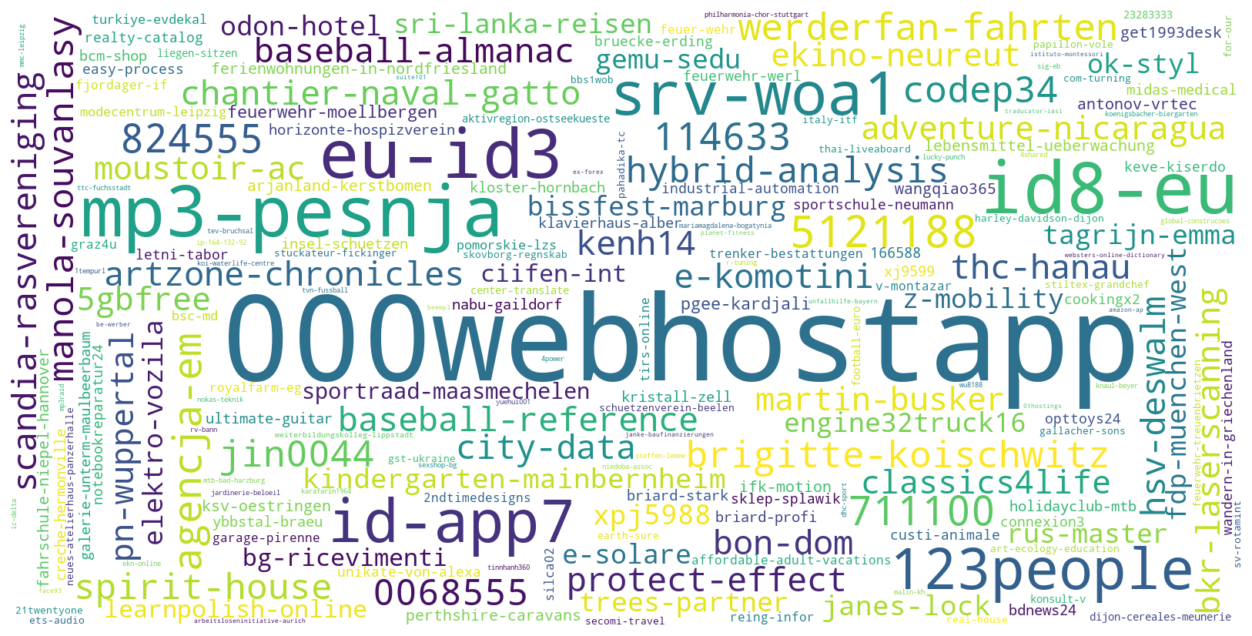

In [42]:
# root_domain에서 단어 추출
root_domains = df["root_domain"].dropna().tolist()
all_root_words = " ".join(root_domains)

# 모든 단어 분리 (하이픈, 언더스코어 포함)
all_root_words_list = re.findall(r'\b[a-zA-Z0-9-_]+\b', all_root_words.lower())

# 단어 빈도 계산
root_word_counts = Counter(all_root_words_list)

# 의심 단어 필터링 (길이 제한, 알파벳 외 문자 포함, 빈도 3회 이상)
suspicious_root_words = {
    word: count for word, count in root_word_counts.items()
    if (len(word) > 5) and (not word.isalpha()) and (count > 2)
}

# 워드클라우드 생성
wordcloud_root_domain = WordCloud(width=1600, height=800, background_color="white").generate_from_frequencies(suspicious_root_words)

# 시각화
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud_root_domain, interpolation="bilinear")
plt.axis("off")
plt.show()